<a href="https://colab.research.google.com/github/jjpeh/W207/blob/master/W207_Home_Price_Prediction_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project: Home Price Prediction

Author: Jun Jun Peh, Matanaporn Cheewadhanaraks

## INTRODUCTION

The objective of this project is to build a machine learning model to predict home prices by using various housing characteristics data from Kaggle’s Ames Housing dataset. We start with exploratory data analysis to study the distribution and statistics of our Sale price and feature variables, and then come up with selected features that we will use to build the model. We aim to leverage several machine learning algorithms we learned from class to buid the most fit model.

## 1) Dataset Download and Preparation

### 1.1 Import necessary packages for analysis

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV

### 1.2 Import Dataset from Kaggle

In [0]:
#!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
# copy the API key to the kaggle directory
!cp kaggle.json ~/.kaggle/
# list all kaggle api dataset
#!kaggle datasets list
# download dataset from kaggle for the first time
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

The syntax of the command is incorrect.


ModuleNotFoundError: No module named 'google'

In [0]:
# read train and test dataset into dataframe
full_train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(full_train_df.shape)
full_train_df.head(10)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [0]:
#Split train data into train data and development data
num_train_half = int(full_train_df.shape[0]*0.2)
dev_df = full_train_df.iloc[:num_train_half]
train_df =  full_train_df.iloc[num_train_half:]

In [0]:
#drop Id column which is not relevant to what we will be using
train_df.drop(['Id'], axis = 1, inplace = True)
train_df.head()

C:\Users\Ploy\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
292,50,RL,60.0,11409,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2009,WD,Normal,131000
293,60,RL,NaN,16659,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,235000
294,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,167000
295,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
296,50,RM,75.0,13710,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,152000


## 2) EXPLORATORY DATA ANALYSIS (EDA)

### 2.1 Initial Features Study

In [0]:
# look at all features available
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [0]:
print("Number of features: ", len(train_df.columns))

Number of features:  80


Text(0.5,1,'Bar Chart of Home Features with Most Missing Values')

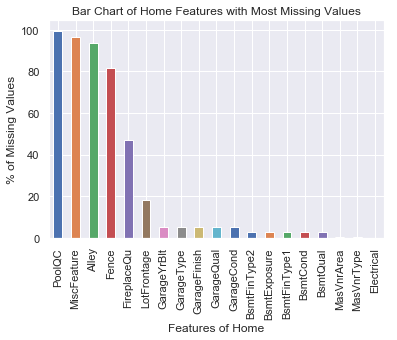

In [0]:
# check for null value in features
null_feature = train_df.isnull().sum()
pcnt_null = null_feature/(len(train_df))*100   # convert to % missing
pcnt_null = pcnt_null[pcnt_null>0]     # only display features with missing values
pcnt_null.sort_values(inplace=True, ascending=False)
pcnt_null.plot.bar()
plt.xlabel("Features of Home")
plt.ylabel("% of Missing Values")
plt.title("Bar Chart of Home Features with Most Missing Values")

In [0]:
# select top NA features to drop from study
null_features_to_drop = pcnt_null.index[0:5]
null_features_to_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')

There are some features with a lot of missing values in the dataset, which could be a disturbance to our study. The 5 features with highest missing values are dropped.

In [0]:
# Drop features with much null values in the dataframe
train_df.drop(null_features_to_drop, axis = 1, inplace = True)

C:\Users\Ploy\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [0]:
# split nonnumerical and numerical features
cat_features = train_df.select_dtypes(include=['object'])
num_features = train_df.select_dtypes(exclude=['object'])

print("nonnumerical features:", len(cat_features.columns))
print("numerical features:", len(num_features.columns))

nonnumerical features: 38
numerical features: 37


In total, we are left with 75 features in total - 37 numerical features and 38 non-numerical features


We then convert the nonnumerical features into dummy variables 

In [0]:
#Encode categorical variables using dummies
train_df_dummy = pd.get_dummies(train_df, drop_first=True)
#check number of features
len(train_df_dummy.columns)

229

#### Select top 25 features with highest correlation with Sale Price

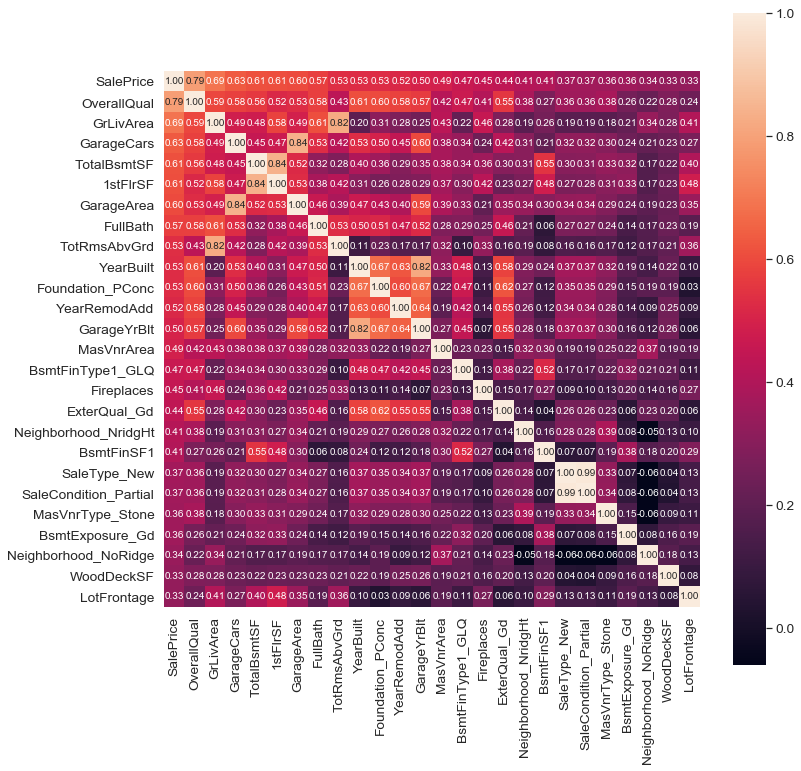

In [0]:
# Top 25 Heatmap
k = 26 #number of variables for heatmap
#drop null values for correlation calculation
train_df_nonull = train_df_dummy.dropna()  
corrmat = train_df_nonull.corr()
hi_cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df_nonull[hi_cols].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=hi_cols.values, xticklabels=hi_cols.values, ax = ax)
plt.show()

In [0]:
# assign top 25 features that correlates to Sales Price in new dataframe
#top25_df = train_df[hi_cols[1:]]   # slice out SalePrice as it's outcome variable
top25_df = train_df_nonull[hi_cols]
top25_df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt,...,ExterQual_Gd,Neighborhood_NridgHt,BsmtFinSF1,SaleType_New,SaleCondition_Partial,MasVnrType_Stone,BsmtExposure_Gd,Neighborhood_NoRidge,WoodDeckSF,LotFrontage
292,131000,5,1716,1,768,1148,281,1,8,1949,...,0,0,292,0,0,0,0,0,0,60.0
294,167000,6,1644,2,1416,1644,418,1,7,1953,...,0,0,1285,0,0,1,0,0,110,80.0
295,142500,6,1003,2,1003,1003,588,1,6,1984,...,0,0,819,0,0,0,0,0,120,37.0
296,152000,5,1558,1,910,910,282,1,6,1950,...,0,0,420,0,0,0,0,0,289,75.0
297,239000,7,1950,2,975,975,576,2,7,1997,...,1,0,649,0,0,0,0,0,0,66.0


### 2.2 Analysis on Outcome Variable: Sales Price

Text(0.5,1,'Histogram of log(Sales Price)')

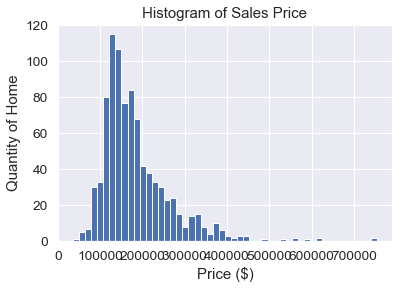

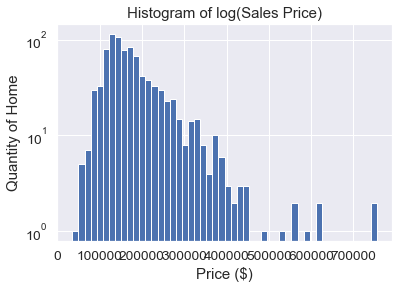

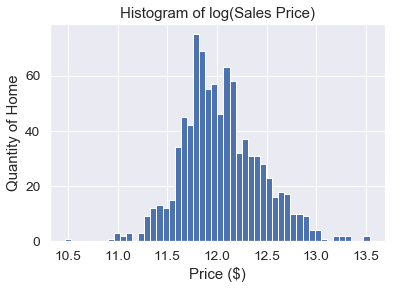

In [0]:
# Transformation on variables
transform_df = top25_df.copy() # create a copy on df to retain original data. transform_df will be used to store log values
transform_df['SalePrice'] = np.log(transform_df['SalePrice'])

# some initial plots on SalesPrice
plt.figure(1)
plt.hist("SalePrice", bins=50, data=top25_df)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of Sales Price")

plt.figure(2)
#sns.distplot(top25_df['SalePrice'])
plt.hist("SalePrice", bins=50, data=top25_df, log=True)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of log(Sales Price)")

# plot 3 is the expected log transformation
plt.figure(3)
plt.hist("SalePrice", bins=50, data=transform_df, log=False)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of log(Sales Price)")

Natural log transformation was performed on the outcome variable 'SalePrice' to obtain a normal distribution.

Text(0.5,1,'Histogram of log(Sales Price) after removing outliers')

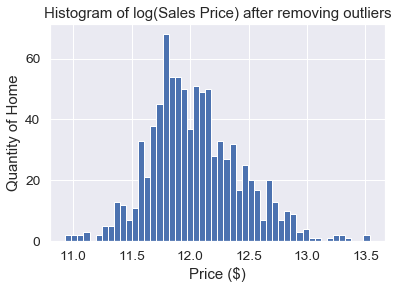

In [0]:
# Removing outliers from SalePrice

transform_df = transform_df[transform_df['SalePrice']>10.6]

plt.figure(1)
plt.hist("SalePrice", bins=50, data=transform_df, log=False)
plt.xlabel("Price ($)")
plt.ylabel("Quantity of Home")
plt.title("Histogram of log(Sales Price) after removing outliers")

### 2.3 Analysis of Selected Categorical Features

In this section, we have selected some of the categorical features with high correlation with sale prices and take a deeper look into their relationship

In [0]:
#function to create boxplot
def priceboxplot(var):
    data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);
    
  

#### 2.3.1 Overall Quality

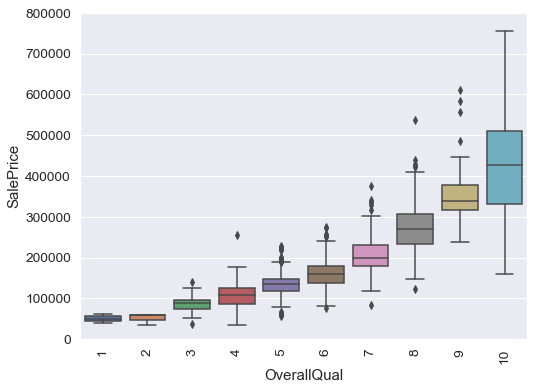

In [0]:
priceboxplot('OverallQual')

Overall quality feature variable, ranging from 1 to 10, has a very strong positive correlation with sales price.  The houses with overall quality rating 10, however, has the widest ranges of sales values

#### 2.3.2 Year Built

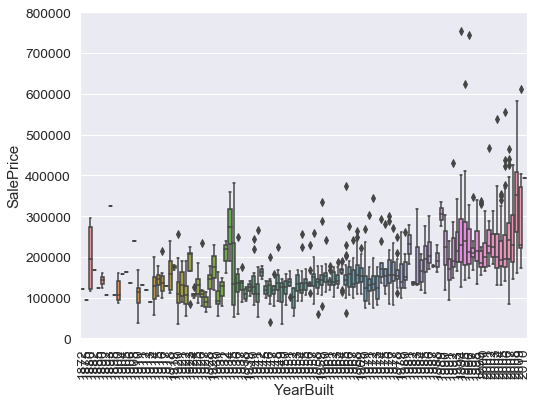

In [0]:
priceboxplot("YearBuilt")

This variable has quite a strong positive relationship with Saleprices and highly correlated with one another. The newer the house, the higher the value.

#### 2.3.3 Foundation

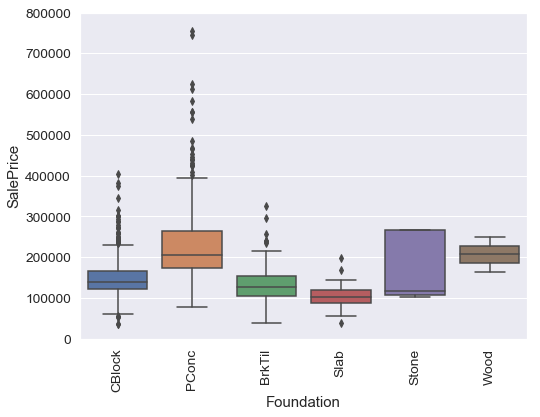

In [0]:
priceboxplot("Foundation")

We notice that on average the houses with concrete foundation attain higher valuation

#### 2.3.4 Rating of basement finished area

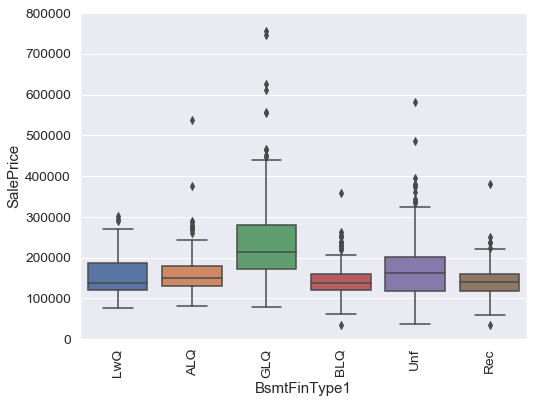

In [0]:
priceboxplot("BsmtFinType1")

 The houses that have good basement rating tend to have higher prices.

#### 2.3.5) Neighborhood

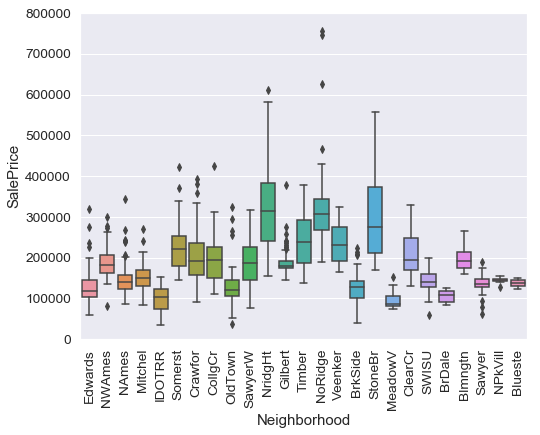

In [0]:
priceboxplot("Neighborhood")

Home prices also varies by location. We notice that Stone Brook and Northridge are rich neighboorhood. On the other hand, in some areas such as Meadow Village or Iowa DOT and Rail Road, home prices are distinctively low.

### 2.4 Analysis of Selected Numerical Features

In [0]:
# summary of top features with numeric values
top25_df.describe()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,1stFlrSF,GarageArea,FullBath,TotRmsAbvGrd,YearBuilt,...,ExterQual_Gd,Neighborhood_NridgHt,BsmtFinSF1,SaleType_New,SaleCondition_Partial,MasVnrType_Stone,BsmtExposure_Gd,Neighborhood_NoRidge,WoodDeckSF,LotFrontage
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000
mean,184748.343367,6.197324,1526.903010,1.872910,1074.550725,1169.529543,499.579710,1.573021,6.584169,1971.770346,...,0.355630,0.063545,439.545151,0.099220,0.101449,0.102564,0.088071,0.031215,93.671126,70.332219
std,83952.721638,1.391971,529.113954,0.659335,453.357933,391.416095,192.891822,0.548402,1.604922,31.047212,...,0.478971,0.244077,471.617620,0.299123,0.302091,0.303558,0.283557,0.173996,122.961440,24.247446
min,35311.000000,2.000000,438.000000,1.000000,0.000000,438.000000,160.000000,0.000000,3.000000,1880.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,131400.000000,5.000000,1144.000000,1.000000,799.000000,894.000000,352.000000,1.000000,6.000000,1952.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,163000.000000,6.000000,1476.000000,2.000000,990.000000,1089.000000,484.000000,2.000000,6.000000,1973.000000,...,0.000000,0.000000,375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000
75%,215000.000000,7.000000,1779.000000,2.000000,1314.000000,1391.000000,592.000000,2.000000,7.000000,2003.000000,...,1.000000,0.000000,700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,80.000000
max,755000.000000,10.000000,5642.000000,4.000000,6110.000000,4692.000000,1418.000000,3.000000,12.000000,2010.000000,...,1.000000,1.000000,5644.000000,1.000000,1.000000,1.000000,1.000000,1.000000,736.000000,313.000000


- Lot frontage (linear feet of street connected to property) has lesser count
- lot area has big variation
- sales prices have some outliers
- MSSubClass should be categorical variable instead of numeric


C:\Users\Ploy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

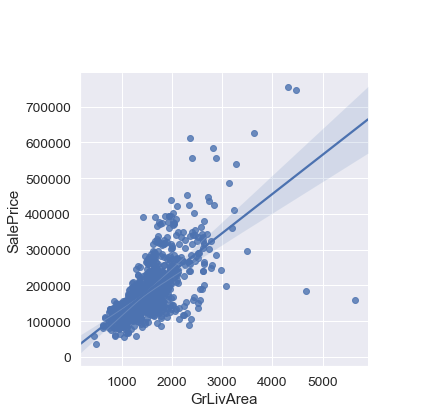

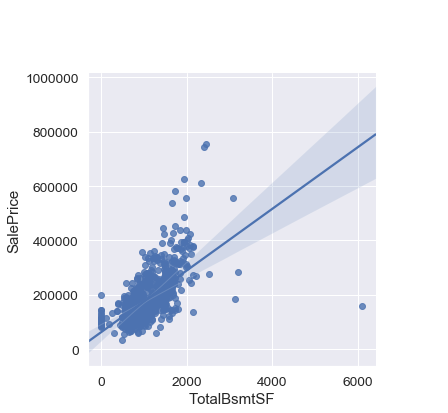

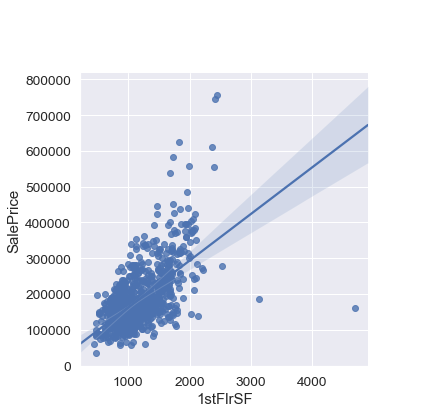

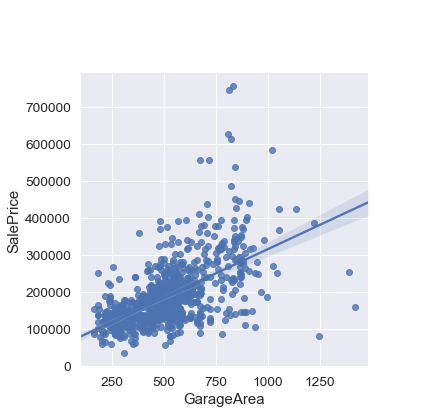

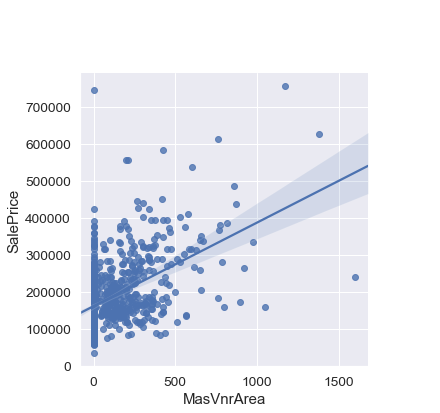

In [0]:
# plot individual multivariate graphs with seaborn
def multivariate_plot(x,y,data,fig_num):
  plt.figure(fig_num)
  g=sns.JointGrid(x=x, y=y, data=data)
  g.plot_joint(sns.regplot)
  g.ax_marg_x.set_axis_off()
  g.ax_marg_y.set_axis_off()

numplots_label = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'MasVnrArea']
# numplots vs SalePrice
for i,item in enumerate(numplots_label):
  multivariate_plot(x=item, y="SalePrice", data=top25_df, fig_num=i)
  

Top 5 numerical features having positive linear relationship with sales price are plotted above. Based on the heatmap, GarageArea and GarageCar seems to have similar correlationship with SalePrice. Thus we decided to pick GarageArea only to be included in our model.
 Some outliers on GrLivArea, TotalBsmtArea, 1stFlrSF, and MasVnrArea with extremely high x-value but low y-value (or vice-versa) do not give much insight to our predictive modeling and thus can be safely removed. 

At the same time, MasVnrArea shows that some homes have zero Masonry Veneer area and yet the home prices varies from low to high. This feature will need to be further investigated.

#### 2.4.3 Outliers Removal

C:\Users\Ploy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

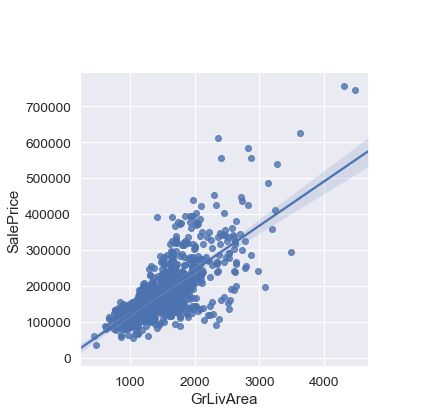

<Figure size 432x288 with 0 Axes>

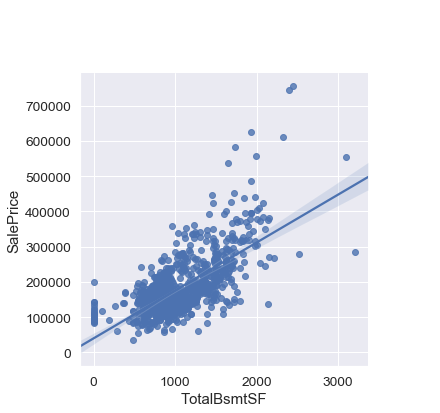

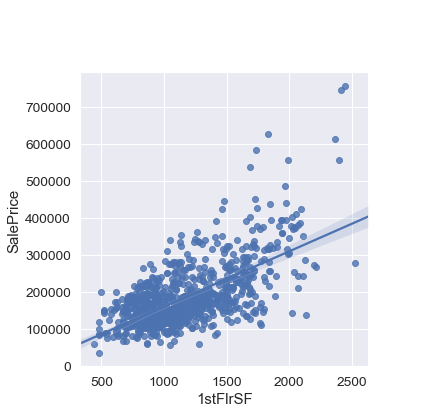

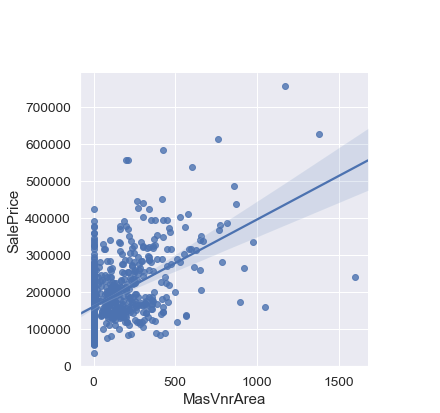

In [0]:
# GrLivArea has outliers at area larger than 4000 but price lower than 200000, that don't obey the linear relationship
top25_df = top25_df.drop(top25_df[(top25_df['GrLivArea']>4000) & (top25_df['SalePrice']<200000)].index)
multivariate_plot(x="GrLivArea", y="SalePrice", data=top25_df, fig_num=2)

# TotalBsmtSF has outlier at extremely large basement area but low sales price
top25_df = top25_df.drop(top25_df[(top25_df['TotalBsmtSF']>6000)].index)
multivariate_plot(x="TotalBsmtSF", y="SalePrice", data=top25_df, fig_num=1)


# 1stFlrSF has outlier at extremely large 1st floor area but low sales price
top25_df = top25_df.drop(top25_df[(top25_df['1stFlrSF']>4000)].index)
multivariate_plot(x="1stFlrSF", y="SalePrice", data=top25_df, fig_num=1)

# MasVnrArea has outlier at extremely large 1st floor area but low sales price
top25_df = top25_df.drop(top25_df[(top25_df['MasVnrArea']<100) & (top25_df['SalePrice']>700000)].index)
multivariate_plot(x="MasVnrArea", y="SalePrice", data=top25_df, fig_num=1)


In [0]:
# save important numeric features here for modeling
#good_features_numeric = ['OverallCond', 'YearBuilt']

#### 2.4.4 Transformation

count     894.000000
mean     1971.663311
std        31.042536
min      1880.000000
25%      1952.000000
50%      1973.000000
75%      2003.000000
max      2010.000000
Name: YearBuilt, dtype: float64
count    894.000000
mean      38.336689
std       31.042536
min        0.000000
25%        7.000000
50%       37.000000
75%       58.000000
max      130.000000
Name: HouseAge, dtype: float64


C:\Users\Ploy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

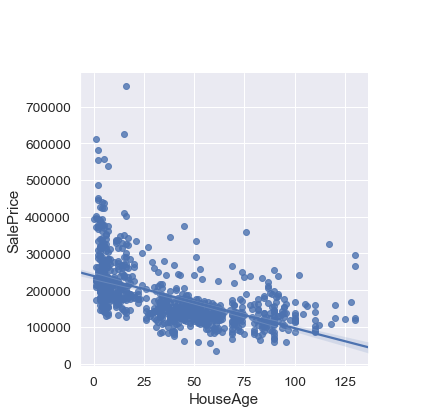

In [0]:
# transform YearBuilt into Age of House being build makes more sense.
print(top25_df['YearBuilt'].describe())
# created new column 'HouseAge'
top25_df['HouseAge'] = abs(2010 - top25_df['YearBuilt'])
print(top25_df['HouseAge'].describe())
multivariate_plot(x="HouseAge", y="SalePrice", data=top25_df, fig_num=1)



SalePrice depreciates with the age of house.

#### 2.4.5 Final Dataframe from EDA

This dataframe will contain the filtered features that have reasonable and highest correlation with SalePrice of house. It will be used as the base for our statistical modeling.

In [0]:
# transform_df = top25_df.copy() # create a copy on df to retain original data. transform_df will be used to store log values
# Drop features with much null values in the dataframe
redundant_features_to_drop = ['YearBuilt', 'GarageCars']
transform_df.drop(redundant_features_to_drop, axis = 1, inplace = True)
print('features on final dataframe for modeling:\n', transform_df.columns)


features on final dataframe for modeling:
 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
       'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'Foundation_PConc',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinType1_GLQ',
       'Fireplaces', 'ExterQual_Gd', 'Neighborhood_NridgHt', 'BsmtFinSF1',
       'SaleType_New', 'SaleCondition_Partial', 'MasVnrType_Stone',
       'BsmtExposure_Gd', 'Neighborhood_NoRidge', 'WoodDeckSF', 'LotFrontage'],
      dtype='object')


## 3) MODELING

In [0]:
# separate SalePrice as train label
train_label = top25_df.pop('SalePrice')
dev_label = dev_df.pop('SalePrice')
print(train_label.head())
print(train_data.shape)

292    131000
294    167000
295    142500
296    152000
297    239000
Name: SalePrice, dtype: int64
(715, 26)


In [0]:
#extract list of features that we would like to run model
selected_feature = list(top25_df.columns)

#convert feature data into matrix
train_data_matrix = top25_df.as_matrix(columns = selected_feature)
train_label_matrix = train_label.as_matrix()
dev_data_matrix = dev_df.as_matrix(columns = selected_feature)
dev_label_matrix = dev_label.as_matrix()

#normalize the scale
train_matrix_scaled = scaler.transform(train_data_matrix)
dev_matrix_scaled_raw = scaler.transform(dev_data_matrix)
dev_matrix_scaled = np.nan_to_num(dev_X_scaled_raw)

print(train_matrix_scaled.shape)    
print(train_label_matrix.shape)  
print(dev_matrix_scaled.shape)
print(dev_label_matrix.shape)

(894, 26)
(894,)
(292, 26)
(292,)


C:\Users\Ploy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\Ploy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Ploy\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\Ploy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### 3.2 Linear Regression Model

In [0]:
# use linear regression as 1st model
model1_lr = LinearRegression()
model1_lr.fit(train_matrix_scaled, train_label_matrix)
lr_pred = model1_lr.predict(dev_matrix_scaled)
coeff = model1_lr.coef_
print('LR Mean squared error: {:.3}'.format(mean_squared_error(dev_label, lr_pred)))
print('LR Reg R2 score: {:.3}'.format(r2_score(dev_label, lr_pred)))

# JJ comment: F1 score only takes in 1D-array. we will use this if we want to analyze f1score feature by feature 
###print('LR Reg F1 score: {:.3}'.format(f1_score(dev_label, pred)))

### remember that SalePrice has been log transformed. need to use np.exp() to convert it back to actual SalePrice

LR Mean squared error: 9.79e+08
LR Reg R2 score: 0.823


In [0]:
# check coefficient on each label
#print(coeff)
print(dev_data.columns.tolist())

lr_list = [('Features', dev_data.columns.tolist()),
         ('Coefficients', coeff.tolist()),
         ]
lr_df = pd.DataFrame.from_items(lr_list)
lr_df

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'Foundation_PConc', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinType1_GLQ', 'Fireplaces', 'ExterQual_Gd', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'SaleType_New', 'SaleCondition_Partial', 'MasVnrType_Stone', 'BsmtExposure_Gd', 'Neighborhood_NoRidge', 'WoodDeckSF', 'LotFrontage', 'HouseAge']


C:\Users\Ploy\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


,Features,Coefficients
0,OverallQual,19580.295707
1,GrLivArea,30035.843058
2,GarageCars,1112.589742
3,TotalBsmtSF,12879.156521
4,1stFlrSF,-3724.745260
5,GarageArea,3209.400147
6,FullBath,-797.519132
7,TotRmsAbvGrd,-1661.415831
8,YearBuilt,2384.506764
9,Foundation_PConc,4116.593431


Above dataframe lists the coefficient of each of the top 25 features on SalePrice.

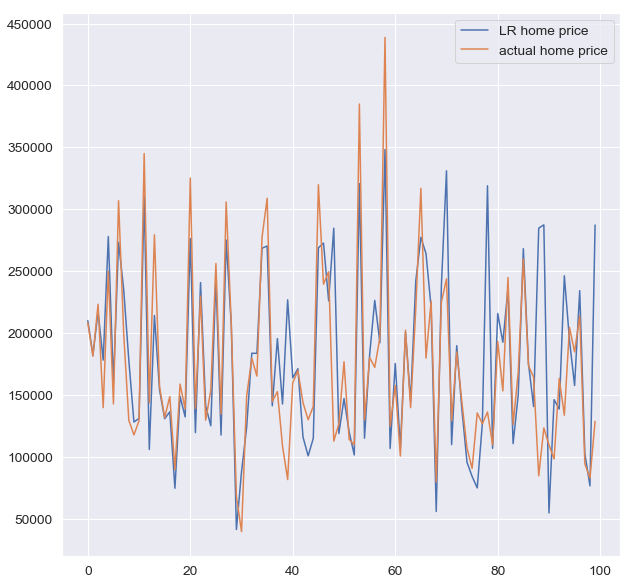

In [0]:
#show the comparison between predicted vs actual homeprice in the development data
fig, ax = plt.subplots(figsize=(10,10))
#plt.plot(predicted_labels[0:100], label = "KNN predicted home price")
plt.plot(lr_pred[0:100], label = "LR home price")
plt.plot(dev_label_matrix[0:100], label = "actual home price")
plt.legend(loc='upper right')

Linear Regression gives us a relatively well baseline prediction of home price with R-squared score of 0.823.

### 3.3 KNN Regression Model 

In [0]:
#search for optimal k value
k_values = list(range(1,15,2))
model_knn = KNeighborsRegressor()
param_grid_knn = dict(n_neighbors=k_values)
grid_knn = GridSearchCV(model_knn, param_grid_knn, cv = 5)
grid_knn.fit(train_matrix_scaled, train_label)
knn_best_val = grid_knn.best_params_
print("Optimal k value:")
print(grid_knn.best_params_,)

Optimal k value:
{'n_neighbors': 3}


R squared: 0.664
Mean squared error: 43083.8499716954


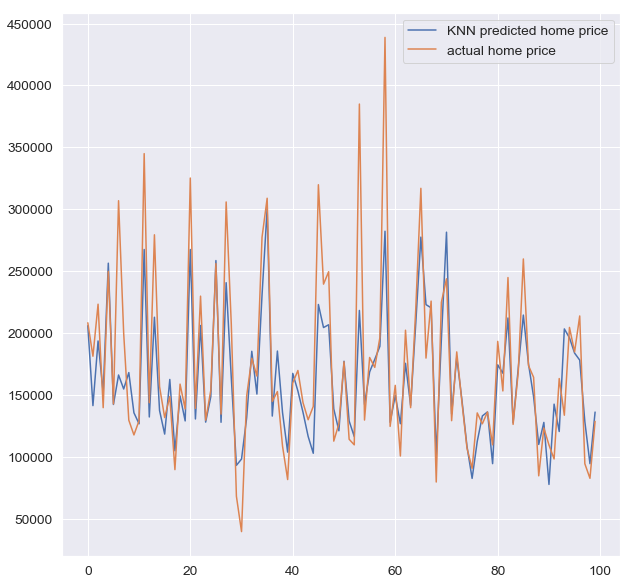

In [0]:
#fit knn model using best k value obtained above
knn = KNeighborsRegressor(n_neighbors=knn_best_val.get('n_neighbors'), weights='distance') # initialize the model
knn.fit(train_matrix_scaled, train_label)
predicted_label = knn.predict(dev_matrix_scaled)

#show the comparison between predicted vs actual homeprice in the development data
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(predicted_label[0:100], label = "KNN predicted home price")
plt.plot(dev_label[0:100], label = "actual home price")
plt.legend(loc='upper right')

print("R squared:", round(knn.score(dev_X_scaled, dev_label),3))
print("Mean squared error:", np.sqrt(mean_squared_error(dev_label, predicted_label)))

## 4) CONCLUSION (Benchmark)

This submission contains data processing and feature engineering on Kaggle's house prices prediction. After some data cleaning, we selected top 25 features that have highest (and reasonable) correlation with sales price. These features are then being used as input to our predictive modeling. For benchmark purpose, we selected two simple models, which are Linear Regression and KNN, to get a baseline prediction of average house sale price.

### Discussion on some improvements to be done and omitted variables to be considered

## 5) REFERENCE & ADDITIONAL RESOURCES

References from Kaggle:
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
- https://www.kaggle.com/harlfoxem/house-price-prediction-part-2
- https://www.kaggle.com/dgawlik/house-prices-eda/notebook
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

References on Python:
- https://seaborn.pydata.org/tutorial/distributions.html